In [109]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [110]:
train_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train'
test_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/val'

In [111]:
trainfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_train_final.csv')
trainfinal

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V
...,...,...,...,...,...
35425,9659.jpg,30-39,Female,Black,VI
35426,967.jpg,40-49,Female,Black,VI
35427,9676.jpg,30-39,Female,Black,VI
35428,9703.jpg,20-29,Female,Black,VI


In [112]:
testfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_test_final.csv')
testfinal

,file,age,gender,race,phototype
0,100.jpg,20-29,Female,East Asian,III
1,1000.jpg,20-29,Male,Latino_Hispanic,IV
2,10000.jpg,20-29,Female,East Asian,III
3,10001.jpg,20-29,Female,Southeast Asian,V
4,10004.jpg,20-29,Male,Southeast Asian,V
...,...,...,...,...,...
4510,9476.jpg,30-39,Female,Black,VI
4511,9501.jpg,40-49,Female,Black,VI
4512,9560.jpg,30-39,Female,Black,VI
4513,9561.jpg,20-29,Female,Black,VI


In [113]:
Name = trainfinal['phototype'].unique().tolist()
print(Name)
print(len(Name))

['III', 'V', 'I & II', 'IV', 'VI']
5


In [114]:
Class_count_1, Class_count_2, Class_count_3, Class_count_4,Class_count_5= trainfinal['phototype'].value_counts()
# Separate class
Class_count_1 = trainfinal[trainfinal['phototype'] == "I & II"]
Class_count_2 = trainfinal[trainfinal['phototype'] == "III"]
Class_count_3 = trainfinal[trainfinal['phototype'] == "IV"]
Class_count_4 = trainfinal[trainfinal['phototype'] == "V"]
Class_count_5 = trainfinal[trainfinal['phototype'] == "VI"]# print the shape of the class
print('class 1:', Class_count_1.shape)
print('class 2:', Class_count_2.shape)
print('class 3:', Class_count_3.shape)
print('class 4:', Class_count_4.shape)
print('class 5:', Class_count_5.shape)

class 1: (7086, 5)
class 2: (7086, 5)
class 3: (7086, 5)
class 4: (7086, 5)
class 5: (7086, 5)


In [115]:
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [116]:
trainfinal['phototype2']=trainfinal['phototype'].map(normal_mapping)
testfinal['phototype2']=testfinal['phototype'].map(normal_mapping)

In [117]:
!pip install imutils

In [118]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

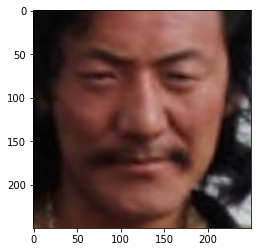

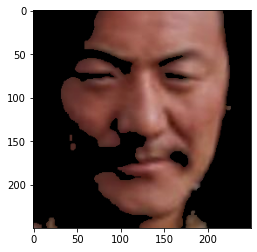

In [134]:
import imutils
# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
path0='../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train/1005.jpg'
image =  cv2.imread(path0)
# Resize image to a width of 250
image = imutils.resize(image,width=250)

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()


# Apply Skin Mask
skin = extractSkin(image)

plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()

In [120]:
def removeBlack(estimator_labels, estimator_cluster):


  # Check for black
  hasBlack = False

  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)


  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)

  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]



    # Check if the color is [0,0,0] that if it is black
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break


  return (occurance_counter,estimator_cluster,hasBlack)

In [121]:
trainX=[]
trainY0=[]
for im in tqdm(os.listdir(train_dir)[0:10000]):
    image=cv2.imread(os.path.join(train_dir,im))
    if im[-4:]=='.jpg':
        lists=trainfinal[trainfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            image = imutils.resize(image,width=250)
            skin = extractSkin(image)
            skin=cv2.resize(image,(32,32))
            trainX+=[skin]
            trainY0+=[count]

100%|██████████| 10000/10000 [01:37<00:00, 102.10it/s]


In [122]:
testX=[]
testY0=[]
for im in tqdm(os.listdir(test_dir)):
    image=cv2.imread(os.path.join(test_dir,im))
    if im[-4:]=='.jpg':
        lists=testfinal[testfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            image = imutils.resize(image,width=250)
            skin = extractSkin(image)
            skin=cv2.resize(image,(32,32))
            testX+=[skin]
            testY0+=[count]

100%|██████████| 4535/4535 [00:22<00:00, 203.03it/s]


In [123]:
labels1=to_categorical(trainY0)
trainY=np.array(labels1)

In [124]:
trainX=np.array(trainX)
testX=np.array(testX)

In [125]:
trainx,testx,trainy,testy=train_test_split(trainX,trainY,test_size=0.2,random_state=10)

In [126]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [127]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [128]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [129]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [130]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

Epoch 1/100
250/250 [==============================] - 24s 55ms/step - loss: 2.2103 - accuracy: 0.2360 - val_loss: 1.5857 - val_accuracy: 0.3162
Epoch 2/100
250/250 [==============================] - 11s 45ms/step - loss: 1.5511 - accuracy: 0.3036 - val_loss: 1.5390 - val_accuracy: 0.3117
Epoch 3/100
250/250 [==============================] - 11s 42ms/step - loss: 1.5352 - accuracy: 0.3164 - val_loss: 1.5444 - val_accuracy: 0.3102
Epoch 4/100
250/250 [==============================] - 11s 44ms/step - loss: 1.5267 - accuracy: 0.3384 - val_loss: 1.5513 - val_accuracy: 0.2981
Epoch 5/100
250/250 [==============================] - 11s 46ms/step - loss: 1.5233 - accuracy: 0.3194 - val_loss: 1.5121 - val_accuracy: 0.3457
Epoch 6/100
250/250 [==============================] - 11s 45ms/step - loss: 1.5054 - accuracy: 0.3364 - val_loss: 1.5204 - val_accuracy: 0.3277
Epoch 7/100
250/250 [==============================] - 12s 46ms/step - loss: 1.4989 - accuracy: 0.3474 - val_loss: 1.5047 - val_ac

KeyboardInterrupt: 

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

In [ ]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

In [ ]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

In [ ]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

# CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the number of classes
num_classes = 5

# Create the model
model1 = Sequential()
# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))


# Add flatten layer
model1.add(Flatten())

# Add fully connected layers
model1.add(Dense(128, activation='relu'))

# Add output layer
model1.add(Dense(num_classes, activation='softmax'))


In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cnnModel=model1.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

In [ ]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

In [ ]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

In [ ]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()